In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import hw3_helper_utils
import cv2

In [11]:
def show_img(img, title=""):
    M, N = img.shape
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.text(
        M + M // 35,
        N // 2,
        f"Shape: {img.shape}\nType: {img.dtype}\nrange: [{np.min(img):.4f}, {np.max(img):.4f}]",
        style="italic",
        bbox={"facecolor": "red", "alpha": 0.5},
    )
    ax.axis("off")
    plt.show()


def my_wiener_filter(
    y: np.ndarray, h: np.ndarray, K: float, Sv: np.ndarray, Sx: np.ndarray, use_K: bool
) -> np.ndarray:
    H = np.fft.fft2(h, s=y.shape)
    Y = np.fft.fft2(y)
    X_hat = (
        np.conj(H) / (np.abs(H) ** 2 + 1 / K) * Y
        if use_K
        else np.conj(H) / (np.abs(H) ** 2 + Sv / Sx) * Y
    )
    x_hat = np.fft.ifft2(X_hat).real
    return x_hat

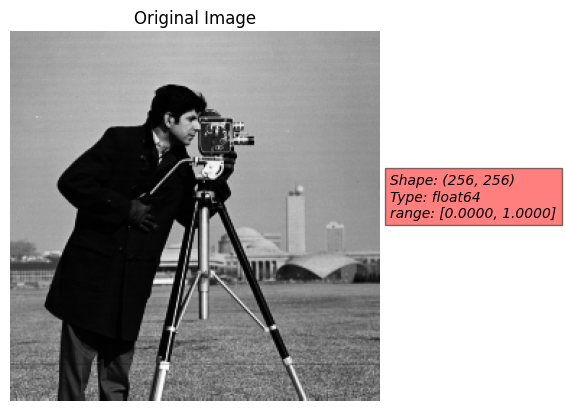

In [12]:
image_path = "data/cameraman.tif"

x = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
x = (x - np.min(x)) / (np.max(x) - np.min(x))
show_img(x, "Original Image")

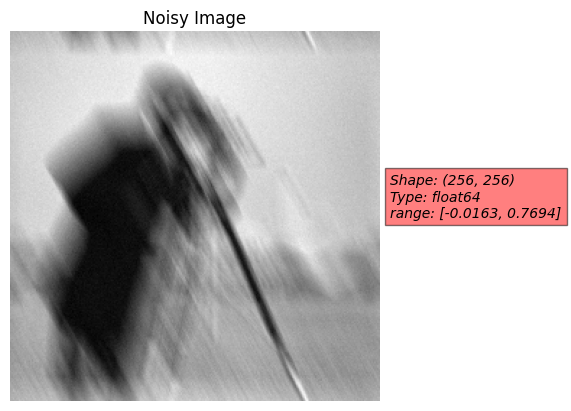

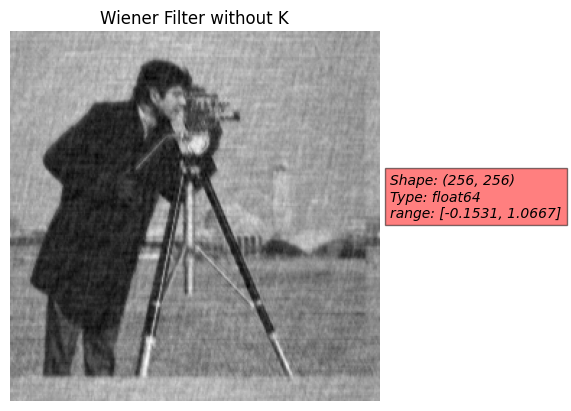

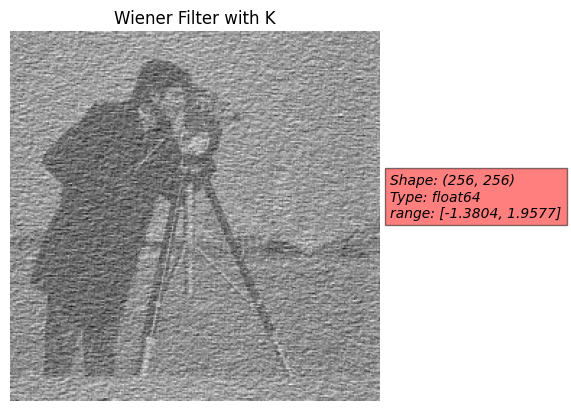

In [13]:
white_noise_level = 0.01
length = 40
angle = 30

v = white_noise_level * np.random.randn(*x.shape)
h = hw3_helper_utils.create_motion_blur_filter(length=length, angle=angle)
y = convolve(x, h, mode="wrap") + v

Sv = np.abs(np.fft.fft2(v)) ** 2
Sx = np.abs(np.fft.fft2(x)) ** 2

x_hat_no_K = my_wiener_filter(y=y, h=h, K=np.inf, Sv=Sv, Sx=Sx, use_K=False)
x_hat_with_K = my_wiener_filter(y=y, h=h, K=1e5, Sv=Sv, Sx=Sx, use_K=True)

show_img(y, "Noisy Image")
show_img(x_hat_no_K, "Wiener Filter without K")
show_img(x_hat_with_K, "Wiener Filter with K")

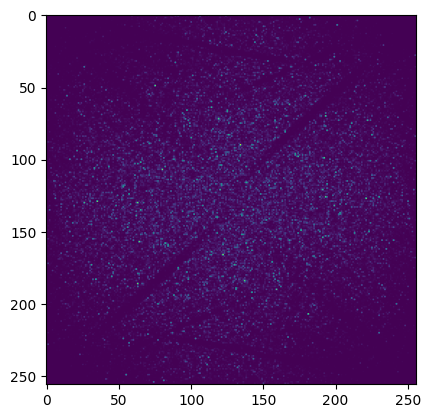

In [17]:
ratio = Sv / Sx
plt.imshow(np.log(ratio + 1))